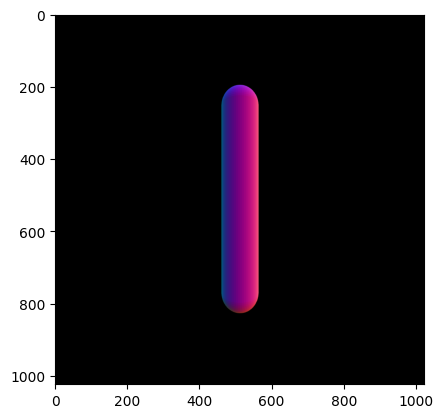

In [169]:
import imageio
from renderObj import renderNomral, loadAndScale
import pyrender
import trimesh
from pyrender.shader_program import ShaderProgramCache
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import cv2
r = pyrender.OffscreenRenderer(viewport_width=1024, viewport_height=1024)
plyPath = './testData/cow.obj'
r._renderer._program_cache = ShaderProgramCache(shader_dir="shaders")
camera_pose = np.array(
    [[ 1,  0,  0,  0],
     [ 0,  0, -1, -10],
     [ 0,  1,  0,  0],
     [ 0,  0,  0,  1]]
)

scene = pyrender.Scene(bg_color=(0, 0, 0))
scene.add(pyrender.Mesh.from_trimesh(trimesh.primitives.Capsule(), smooth = False))
camera = pyrender.PerspectiveCamera(yfov=np.pi / 2.0, aspectRatio=1.0, znear = 0.5, zfar = 40)
scene.add(camera, pose=camera_pose)
normals, depth = r.render(scene)
#normals,depth = renderNomral(r,loadAndScale(plyPath),r_angle=90)
plt.imshow(normals)

In [178]:
import cv2
import numpy as np
from scipy.spatial import KDTree
from scipy.optimize import minimize
from scipy.optimize import curve_fit




def display_contour(contours, image_size):
    # 创建一个全黑的图像
    blank_image = np.zeros(image_size, dtype=np.uint8)

    # 在空白图像上绘制轮廓
    cv2.drawContours(blank_image, contours, -1, (255, 0, 0), 1)

    # 使用matplotlib显示图像
    plt.imshow(blank_image, cmap='gray')
    plt.show()

def display_two_contour(contour1,contour2, image_size):
    # 创建一个全黑的图像
    blank_image = np.zeros(image_size, dtype=np.uint8)

    # 在空白图像上绘制轮廓
    cv2.drawContours(blank_image, contour1, -1, (255, 0, 0), 1)
    cv2.drawContours(blank_image, contour2, -1, (0, 255, 0), 1)

    # 使用matplotlib显示图像
    plt.imshow(blank_image, cmap='gray')
    plt.show()


def create_contour_line_segments(image, k=5):
    _, binary = cv2.threshold(image, 1, 255, cv2.THRESH_BINARY)
    _, binary_Inv = cv2.threshold(image, 1, 255, cv2.THRESH_BINARY_INV)
    contours, _ = cv2.findContours(binary_Inv, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
    contour_points = []
    point_to_k_points = {}
    for contour in contours:
        for i in range(len(contour) - 1):
            point = tuple(contour[i][0])
            contour_points.append(point)

            # 获取前后k个点
            k_points = []
            for offset in range(-k, k+1):
                idx = (i + offset) % len(contour)
                k_points.append(tuple(contour[idx][0]))

            # 添加点到k_points的映射
            point_to_k_points[point] = k_points
    contour_points = np.array(contour_points, dtype=np.float32)

    return KDTree(np.array(contour_points)), point_to_k_points,binary

def calculate_nearest_line_vectors(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    vector_image = np.zeros((*gray.shape, 3), dtype=np.uint8)
    tree, point_to_k_points,binary = create_contour_line_segments(gray)

    contours_B, _ = cv2.findContours(binary, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
    for contours in contours_B:
        for point in contours:
            point_B = point[0]
            if point_B[0] == 0 or point_B[0] == 1023 or point_B[1] == 1023 or point_B[1]==0:
                continue
            dist, index = tree.query(point_B)
            point_A = tuple(tree.data[index])

            # 使用np.polyfit拟合曲线
            k_points = point_to_k_points[point_A]
            x = [point[0] for point in k_points]
            y = [point[1] for point in k_points]
            z = np.polyfit(x, y, 2)
            f = np.poly1d(z)

            # 定义优化目标函数：点到曲线的距离
            def objective(x):
                return (x[0] - point_B[0]) ** 2 + (f(x[0]) - point_B[1]) ** 2

            # 使用scipy.optimize.minimize方法找到距离点B最近的曲线上的点
            result = minimize(objective, point_A, method='Nelder-Mead')
            point_C = (result.x[0], f(result.x[0]))

            # 计算从点B到曲线上的点的向量
            min_vector = np.array(point_C) - np.array(point_B)

            if np.linalg.norm(min_vector) > 0:
                min_vector = (min_vector / np.linalg.norm(min_vector)) * 255
                vector_image[point_B[1], point_B[0], :2] = min_vector

    return vector_image

def fit_curve(points, degree=2):
    x = [point[0] for point in points]
    y = [point[1] for point in points]
    coefficients = np.polyfit(x, y, degree)
    return np.poly1d(coefficients)

def distance_from_point_to_curve(point, curve):

    def distance_to_curve(x):
        return np.sqrt((x - point[0])**2 + (curve(x) - point[1])**2)

    result = minimize(distance_to_curve, point[0])
    return result.fun, result.x[0], curve(result.x[0])

In [179]:
vectormap = calculate_nearest_line_vectors(normals)


C:\Users\pzeug\AppData\Local\Temp\ipykernel_22012\3115679618.py:1: RankWarning: Polyfit may be poorly conditioned
  vectormap = calculate_nearest_line_vectors(normals)
C:\Users\pzeug\AppData\Local\Temp\ipykernel_22012\3115679618.py:1: RankWarning: Polyfit may be poorly conditioned
  vectormap = calculate_nearest_line_vectors(normals)
C:\Users\pzeug\AppData\Local\Temp\ipykernel_22012\3115679618.py:1: RankWarning: Polyfit may be poorly conditioned
  vectormap = calculate_nearest_line_vectors(normals)
C:\Users\pzeug\AppData\Local\Temp\ipykernel_22012\3115679618.py:1: RankWarning: Polyfit may be poorly conditioned
  vectormap = calculate_nearest_line_vectors(normals)
C:\Users\pzeug\AppData\Local\Temp\ipykernel_22012\3115679618.py:1: RankWarning: Polyfit may be poorly conditioned
  vectormap = calculate_nearest_line_vectors(normals)
C:\Users\pzeug\AppData\Local\Temp\ipykernel_22012\3115679618.py:1: RankWarning: Polyfit may be poorly conditioned
  vectormap = calculate_nearest_line_vectors(n

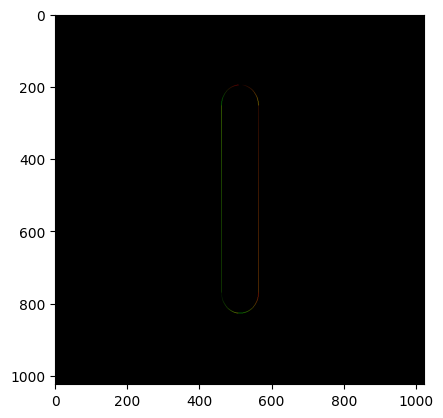

In [180]:
plt.imshow(vectormap)

In [181]:
def draw_vector_on_blank(vectormap, scale=0.5):
    # 创建一个空的RGB图像
    blank_image = np.zeros((*vectormap.shape[0:2], 3), dtype=np.uint8)

    # 遍历图像的每个像素
    for y in range(vectormap.shape[0]):
        for x in range(vectormap.shape[1]):
            vector = vectormap[y, x]

            # 如果向量不是零向量，就在图像上绘制箭头
            if np.any(vector):
                # 根据RGB值计算向量的方向和长度
                dx, dy, _ = vector
                dx *= scale
                dy *= scale

                # 绘制箭头
                end_point = (int(x + dx), int(y + dy))
                cv2.arrowedLine(blank_image, (x, y), end_point, (0, 255, 0), 1)

    return blank_image

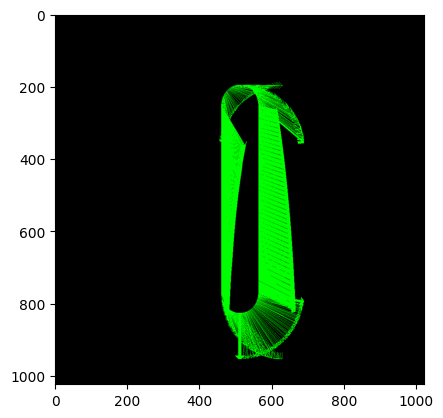

In [182]:
vectors = draw_vector_on_blank(vectormap)
plt.imshow(vectors)